In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [67]:
# Load the dataset
dataset_cyclists = load_dataset('csv', data_files='dataset/cyclists.csv')
dataset_races = load_dataset('csv', data_files='dataset/races.csv')

# Convert to pandas DataFrames
df_cyclists = dataset_cyclists['train'].to_pandas()
df_races = dataset_races['train'].to_pandas()

## Pre processing needed for cyclists 

In [68]:
# Check information about scott-davies in the other dataset to put some value in
df_cyclists[df_cyclists["_url"] == "scott-davies"]

# Delete scott-davies row
df_cyclists = df_cyclists[df_cyclists["_url"] != "scott-davies"]

# Simple imputer for birth year
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit((df_cyclists[["birth_year"]]))
df_cyclists["birth_year"] = imputer.transform(df_cyclists[["birth_year"]]).squeeze()

# Check missing value after imputing
df_cyclists["birth_year"].isnull().sum()

0

## Imputing weight and age

In [69]:
# Keep the _url in the imputation dataset to preserve the reference
df_cyclists_impute_scaling = df_cyclists[['height', 'weight', '_url']].copy()

print("Shape of original DataFrame:", df_cyclists.shape)
print("Shape of imputed DataFrame:", df_cyclists_impute_scaling.shape)

# Normalize/Scale only weight and height (not _url)
scaler = StandardScaler()
df_cyclists_impute_scaling[['weight', 'height']] = scaler.fit_transform(df_cyclists_impute_scaling[['weight', 'height']])

# Initialize Iterative Imputer (Bayesian Ridge for imputation)
iterative_imputer = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=0,
    max_iter=100,
    sample_posterior=True
)

# Fit the imputer and transform the DataFrame (excluding '_url' from the imputation)
imputed_values = iterative_imputer.fit_transform(df_cyclists_impute_scaling[['weight', 'height']])

# Revert scaling for the imputed values
df_imputed_scaling = pd.DataFrame(
    scaler.inverse_transform(imputed_values),  
    columns=['weight', 'height']
)

# Add back the _url column to the imputed DataFrame (preserve cyclist id)
df_imputed_scaling['_url'] = df_cyclists_impute_scaling['_url'].values

# Now you have df_imputed_scaling with _url, weight, and height
print("\nImputed DataFrame:\n", df_imputed_scaling)

# Merge the imputed values back into the original dataset using _url as the key
df_cyclists = df_cyclists.merge(
    df_imputed_scaling[['weight', 'height', '_url']], 
    on='_url', 
    how='left', 
    suffixes=('', '_imputed')
)

# Replace original columns with the imputed values where available
df_cyclists['weight'] = df_cyclists['weight_imputed'].fillna(df_cyclists['weight'])
df_cyclists['height'] = df_cyclists['height_imputed'].fillna(df_cyclists['height'])

# Drop the temporary '_imputed' columns
df_cyclists.drop(columns=['weight_imputed', 'height_imputed'], inplace=True)

# Now df_cyclists has the updated weight and height columns
print("Updated DataFrame with Imputed Values:\n", df_cyclists)

Shape of original DataFrame: (6133, 6)
Shape of imputed DataFrame: (6133, 3)

Imputed DataFrame:
          weight      height                     _url
0     70.057068  187.223027              bruno-surra
1     74.000000  182.000000               gerard-rue
2     69.000000  189.000000                 jan-maas
3     78.000000  192.000000     nathan-van-hooydonck
4     55.000000  171.000000         jose-felix-parra
...         ...         ...                      ...
6128  72.105507  187.435327  juan-jose-martinez-diaz
6129  75.000000  188.000000           inigo-elosegui
6130  58.906714  167.861711           paolo-alberati
6131  58.000000  170.000000        jackson-rodriguez
6132  75.000000  186.000000             ward-vanhoof

[6133 rows x 3 columns]
Updated DataFrame with Imputed Values:
                          _url                  name  birth_year     weight  \
0                 bruno-surra          Bruno  Surra      1964.0  70.057068   
1                  gerard-rue           Gérar

In [70]:
df_cyclists.isnull().sum()

_url           0
name           0
birth_year     0
weight         0
height         0
nationality    0
dtype: int64

## Races

In [71]:
df_races.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,None,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


In [72]:
df_races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

In [73]:
df_races.shape

(589865, 18)

In [74]:
df_races.describe()

,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,position,cyclist_age,delta
count,589388.000000,251086.000000,589865.000000,442820.000000,441671.000000,589865.000000,29933.000000,589865.000000,589752.000000,589865.000000
mean,89.221635,74.601547,166776.180584,2330.469215,2.611611,1101.161178,21.731768,74.219491,28.486208,418.292794
std,54.435330,100.947962,64545.605664,1375.710722,1.491741,380.586928,5.884761,48.404023,3.855631,842.961596
min,18.000000,6.000000,1000.000000,2.000000,1.000000,115.000000,10.000000,0.000000,13.000000,-6906.000000
25%,50.000000,16.000000,152500.000000,1309.000000,1.000000,844.000000,17.000000,32.000000,26.000000,10.000000
50%,80.000000,60.000000,178200.000000,2255.000000,2.000000,988.000000,22.000000,70.000000,28.000000,156.000000
75%,100.000000,100.000000,203500.000000,3273.000000,4.000000,1309.000000,26.000000,112.000000,31.000000,624.000000
max,350.000000,800.000000,338000.000000,6974.000000,5.000000,2047.000000,36.000000,209.000000,56.000000,61547.000000


In [75]:
# check duplicates
dup_df_races = df_races[df_races.duplicated(keep=False)] 

In [76]:
dup_df_races # no dup rows for all the column

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta


## Missing values

In [77]:
# check missing values
df_races.isnull().sum()

_url                        0
name                        0
points                    477
uci_points             338779
length                      0
climb_total            147045
profile                148194
startlist_quality           0
average_temperature    559932
date                        0
position                    0
cyclist                     0
cyclist_age               113
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team           159161
delta                       0
dtype: int64

## Cyclist age

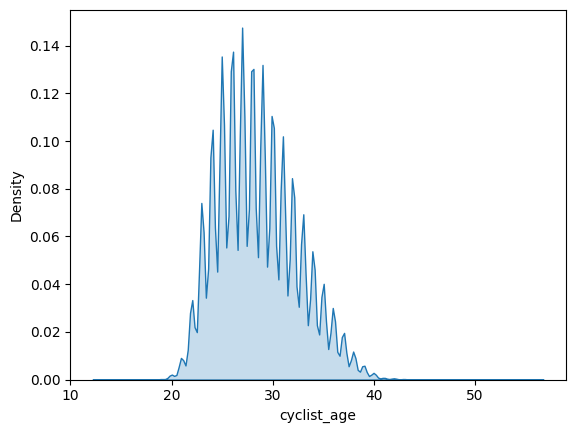

In [78]:
# Kernel Density Estimation
seaborn.kdeplot(df_races["cyclist_age"], fill=True, label="cyclist_age")
plt.show()

Since one cyclists can run multiple races, for matching we have to remove duplicates

In [79]:
df_cyclists_clean = df_cyclists.drop_duplicates(subset=['_url'])
df_races_clean = df_races.drop_duplicates(subset=['cyclist'])

# Print counts after removing duplicates
print(df_cyclists_clean["_url"].count())
print(df_races_clean["cyclist"].count())

# Merge the two DataFrames based on matches between '_url' and 'cyclist'
matches = df_cyclists_clean.merge(df_races_clean, left_on='_url', right_on='cyclist', how='inner')

# Count the number of unique matches
number_of_matches = len(matches)
number_of_matches

6133
6095


6094

In [80]:
matches.head()

,_url_x,name_x,birth_year,weight,height,nationality,_url_y,name_y,points,uci_points,...,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,bruno-surra,Bruno Surra,1964.0,70.057068,187.223027,Italy,vuelta-a-espana/1989/stage-1,Vuelta a España,80.0,NaN,...,NaN,1989-04-24 00:25:33,110,bruno-surra,25.0,True,False,False,None,15.0
1,gerard-rue,Gérard Rué,1965.0,74.000000,182.000000,France,tour-de-france/1997/stage-2,Tour de France,100.0,NaN,...,NaN,1997-07-07 06:27:47,132,gerard-rue,32.0,True,False,False,denmark-1991,0.0
2,jan-maas,Jan Maas,1996.0,69.000000,189.000000,Netherlands,amstel-gold-race/2022/result,Amstel Gold Race,225.0,500.0,...,10.0,2022-04-10 06:07:45,39,jan-maas,26.0,False,False,False,munck-beck-s-1975,386.0
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.000000,192.000000,Belgium,tour-de-france/2022/stage-9,Tour de France,100.0,120.0,...,24.0,2022-07-10 05:14:14,102,nathan-van-hooydonck,27.0,True,False,False,colombia-selle-italia-2002,1655.0
4,jose-felix-parra,José Félix Parra,1997.0,55.000000,171.000000,Spain,volta-a-catalunya/2022/stage-3,Volta Ciclista a Catalunya,50.0,50.0,...,NaN,2022-03-23 04:13:08,28,jose-felix-parra,25.0,True,False,False,spain-1970,17.0


In [81]:
# check missing values
matches.isnull().sum()

_url_x                    0
name_x                    0
birth_year                0
weight                    0
height                    0
nationality               0
_url_y                    0
name_y                    0
points                    0
uci_points             4227
length                    0
climb_total            2784
profile                2799
startlist_quality         0
average_temperature    5674
date                      0
position                  0
cyclist                   0
cyclist_age              12
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team           3389
delta                     0
dtype: int64

Check for cyclists that has made more than one race --> useful for later because of duplicates

In [82]:
# Step 1: Identify rows with missing cyclist_age in df_races
df_missing_age = df_races[df_races["cyclist_age"].isnull()]

# Step 2: Group by cyclist and count the number of races (rows) for each cyclist with missing age
duplicate_cyclists = df_missing_age.groupby("cyclist").size().reset_index(name="race_count")

# Step 3: Filter for cyclists who have more than one race with a missing age
duplicate_cyclists = duplicate_cyclists[duplicate_cyclists["race_count"] > 1]

# Display cyclists with more than one missing cyclist_age entry
print(duplicate_cyclists)


# Check total count of missing cyclist_age values in df_races
missing_count = df_races["cyclist_age"].isnull().sum()
print("Total missing cyclist_age values:", missing_count)

               cyclist  race_count
0      alexandr-osipov          13
1       antonio-zanini           2
7     nicolai-kosyakov          11
9         scott-davies          52
10  sergei-jermachenko          14
12    vladimir-malakov          14
Total missing cyclist_age values: 113


We can manually impute 13 missing values for cyclist_age since we have the year of the race and the nationality of the cyclist

In [83]:
# Extract race year from the url
matches["_year"] = matches["_url_y"].str.extract(r'/(\d{4})/').astype(int)

# Convert birth_year to integer
matches["birth_year"] = matches["birth_year"].astype(int)

# Compute cyclist_age where it is null
matches["cyclist_age"] = np.where(
    matches["cyclist_age"].isnull(),
    matches["_year"] - matches["birth_year"],
    matches["cyclist_age"]
)

# Identify the subset of cyclists with missing cyclist_age in df_races
# We'll filter out cyclists with missing cyclist_age in df_races
df_missing_age = df_races[df_races["cyclist_age"].isnull()]

# Filter only the cyclists from matches that are common with df_races and have missing ages
# 'cyclist' column is used to match both datasets
matches_with_missing_age = matches[matches["cyclist"].isin(df_missing_age["cyclist"])]

# Update df_races with the imputed cyclist_age values for only the matched cyclists
# We will do this based on the 'cyclist' column
df_races.loc[df_races["cyclist"].isin(matches_with_missing_age["cyclist"]), "cyclist_age"] = \
    df_races["cyclist"].map(matches_with_missing_age.set_index("cyclist")["cyclist_age"])

In [84]:
# check missing values
df_races.isnull().sum()

_url                        0
name                        0
points                    477
uci_points             338779
length                      0
climb_total            147045
profile                148194
startlist_quality           0
average_temperature    559932
date                        0
position                    0
cyclist                     0
cyclist_age                52
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team           159161
delta                       0
dtype: int64

### Check which cyclist have no age yet  --> only scott-davies who is not present on the other datasets because we deleted him (all NaN values)

In [85]:
# Check which cyclist have no age yet 
cyclists_with_no_age_yet = df_races[df_races["cyclist_age"].isnull()]
cyclists_with_no_age_yet

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
2063,giro-d-italia/2019/stage-14,Giro d'Italia,80.0,100.0,131000.0,4187.0,4.0,896,NaN,2019-05-25 04:31:35,99,scott-davies,NaN,True,False,False,team-giant-shimano-2014,1752.0
6495,vuelta-a-espana/2020/stage-7,La Vuelta ciclista a España,80.0,100.0,159700.0,2657.0,2.0,692,NaN,2020-10-27 04:05:14,124,scott-davies,NaN,True,False,False,carrera-inoxpran-1985,1018.0
12865,amstel-gold-race/2018/result,Amstel Gold Race,225.0,500.0,263000.0,3496.0,2.0,1139,NaN,2018-04-15 06:39:57,96,scott-davies,NaN,False,False,False,liquigas-2007,290.0
12972,vuelta-a-espana/2020/stage-11,La Vuelta ciclista a España,80.0,100.0,170000.0,5098.0,5.0,692,NaN,2020-10-31 05:26:30,100,scott-davies,NaN,True,False,False,carrera-inoxpran-1985,1937.0
13349,paris-nice/2019/stage-3,Paris - Nice,50.0,60.0,200000.0,896.0,1.0,1099,NaN,2019-03-12 05:16:25,50,scott-davies,NaN,True,False,False,team-giant-shimano-2014,0.0
23038,giro-d-italia/2019/stage-16,Giro d'Italia,80.0,100.0,194000.0,5207.0,4.0,896,NaN,2019-05-28 05:58:48,71,scott-davies,NaN,True,False,False,team-giant-shimano-2014,1344.0
60389,vuelta-a-espana/2020/stage-4,La Vuelta ciclista a España,80.0,100.0,191700.0,1160.0,1.0,692,NaN,2020-10-23 03:54:11,134,scott-davies,NaN,True,False,False,carrera-inoxpran-1985,42.0
68791,giro-d-italia/2019/stage-9,Giro d'Italia,80.0,100.0,34800.0,723.0,3.0,896,NaN,2019-05-19 00:54:29,18,scott-davies,NaN,True,False,False,team-giant-shimano-2014,157.0
75497,giro-d-italia/2019/stage-18,Giro d'Italia,80.0,100.0,222000.0,1478.0,2.0,896,NaN,2019-05-30 05:04:24,138,scott-davies,NaN,True,False,False,team-giant-shimano-2014,500.0
132853,paris-nice/2019/stage-1,Paris - Nice,50.0,60.0,138500.0,1107.0,1.0,1099,NaN,2019-03-10 03:20:17,131,scott-davies,NaN,True,False,False,team-giant-shimano-2014,162.0


In [86]:
# delete 52 null values since they refer only to sott-davies for which we have no info
df_races = df_races[~df_races['cyclist'].isin(cyclists_with_no_age_yet['cyclist'])].copy()

## Compute optimal number of bins

In [87]:
# Sturges rule for approximately Normal distributions
def sturges_bin_count(df_races):
    """Calculate optimal number of bins based on Sturges' rule"""
    return int(np.ceil(np.log2(len(df_races)) + 1))

bins = sturges_bin_count(df_races["cyclist_age"])
print(f"Recommended number of bins: {bins}")

# Freedman-Diaconis Rule is better for data with outliers and skewed distributions
def freedman_diaconis_bin_count(data):
    """Calculate optimal number of bins based on Freedman-Diaconis rule"""
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * iqr * len(data) ** (-1/3)
    return int(np.ceil((data.max() - data.min()) / bin_width))

bins = freedman_diaconis_bin_count(df_races["cyclist_age"])
print(f"Recommended number of bins: {bins}")

Recommended number of bins: 21
Recommended number of bins: 378


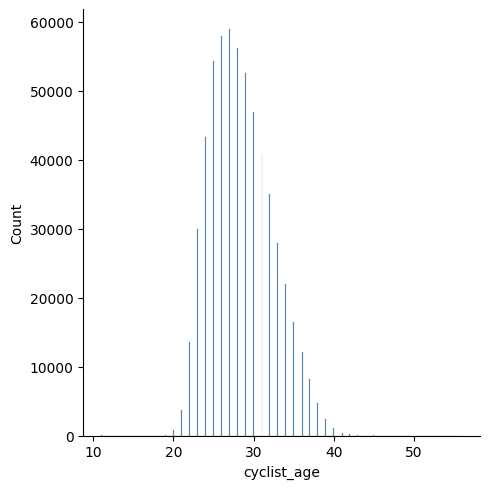

In [88]:
# birht year
seaborn.displot(df_races,
                x="cyclist_age",
                kind="hist",
                row_order="desc",
                bins=378)

In [89]:
df_races.isnull().sum() # zero missing value for age

_url                        0
name                        0
points                    477
uci_points             338779
length                      0
climb_total            147045
profile                148194
startlist_quality           0
average_temperature    559880
date                        0
position                    0
cyclist                     0
cyclist_age                 0
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team           159161
delta                       0
dtype: int64

In [90]:
df_races.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,None,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


In [91]:
test = df_races[df_races["profile"] == 2.0]
test.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
962,volta-a-catalunya/2018/stage-7,Volta Ciclista a Catalunya,50.0,50.0,154800.0,2008.0,2.0,659,NaN,2018-03-25 03:28:04,0,simon-yates,26.0,True,False,False,norway-1987,0.0
963,volta-a-catalunya/2018/stage-7,Volta Ciclista a Catalunya,50.0,50.0,154800.0,2008.0,2.0,659,NaN,2018-03-25 03:28:17,1,marc-soler,25.0,True,False,False,spain-1970,13.0
964,volta-a-catalunya/2018/stage-7,Volta Ciclista a Catalunya,50.0,50.0,154800.0,2008.0,2.0,659,NaN,2018-03-25 03:28:22,2,pierre-latour,25.0,True,False,False,team-volksbank-2008,18.0
965,volta-a-catalunya/2018/stage-7,Volta Ciclista a Catalunya,50.0,50.0,154800.0,2008.0,2.0,659,NaN,2018-03-25 03:28:22,3,jarlinson-pantano,30.0,True,False,False,carrera-inoxpran-1985,18.0
966,volta-a-catalunya/2018/stage-7,Volta Ciclista a Catalunya,50.0,50.0,154800.0,2008.0,2.0,659,NaN,2018-03-25 03:28:22,4,jay-mccarthy,26.0,True,False,False,vini-fantini-2013,18.0


# Impute climb total and profile together using race characteristics (race length, race type).

See distributions first

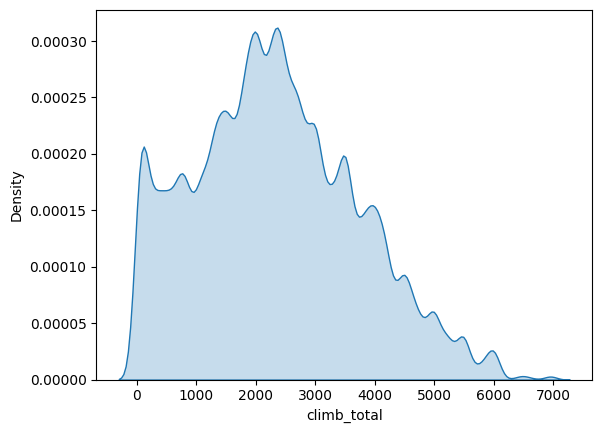

In [92]:
# Kernel Density Estimation
seaborn.kdeplot(df_races["climb_total"], fill=True, label="climb_total")
plt.show()

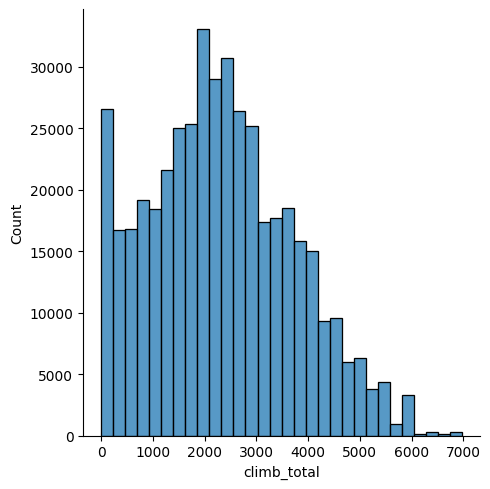

In [93]:
seaborn.displot(df_races,
                x="climb_total",
                kind="hist",
                row_order="desc",
                bins=30)

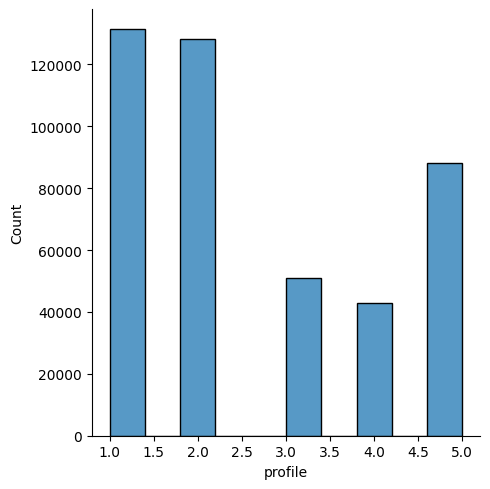

In [94]:
seaborn.displot(df_races,
                x="profile",
                kind="hist",
                row_order="desc",
                bins=10)

In [95]:
# compute for test differences after imputation
climb_total_before_imputation = df_races['climb_total'].dropna() 

## Reduce Skeweness

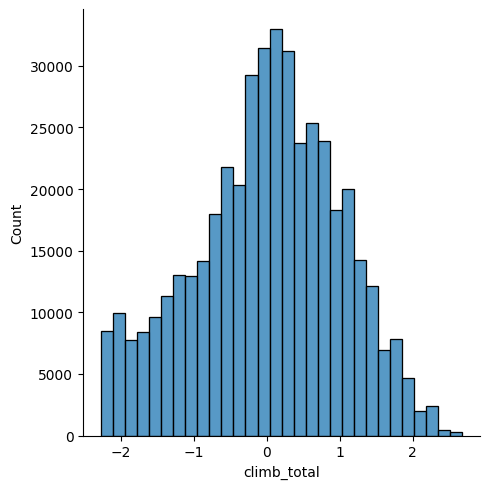

In [96]:
# Apply Yeo-Johnson transformation to reduce skeweness --> OKAY
pt = PowerTransformer(method='yeo-johnson')
df_races['climb_total'] = pt.fit_transform(df_races[['climb_total']])

#bins = sturges_bin_count(df_races["climb_total"])
seaborn.displot(df_races,
            x="climb_total",
            kind="hist",
            row_order="desc",
            bins=30)

## IterativeImputer with KNNRegressor

   climb_total  profile
0       1101.0      1.0
1       1101.0      1.0
2       1101.0      1.0
3       1101.0      1.0
4       1101.0      1.0


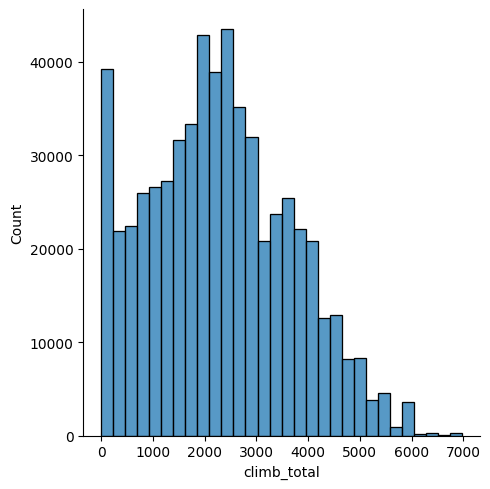

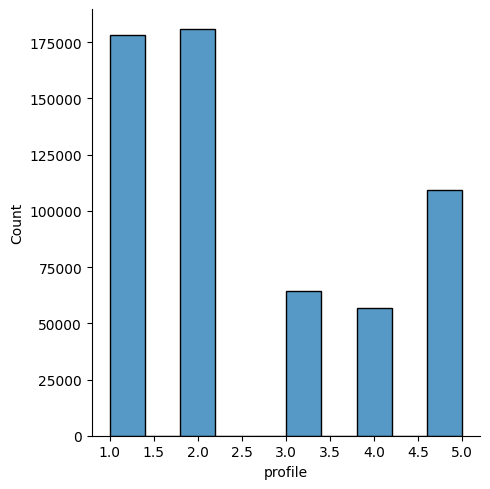

In [97]:
# Scale 
scaler = StandardScaler()
df_races[['climb_total', 'profile', 'length']] = scaler.fit_transform(df_races[['climb_total', 'profile', 'length']])

iterative_imputer = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=3), # 3 is empirical, watching the distr after imputation
    random_state=0,
    max_iter=100,
    sample_posterior=False
)

df_races[['climb_total', 'profile', 'length']] = iterative_imputer.fit_transform(df_races[['climb_total', 'profile', 'length']])

# Inverse the standardization for 'climb_total' and 'profile'
df_races[['climb_total', 'profile', 'length']] = scaler.inverse_transform(df_races[['climb_total', 'profile', 'length']])

# Inverse the Yeo-Johnson transformation on 'climb_total'
df_races['climb_total'] = pt.inverse_transform(df_races[['climb_total']])

# Visualize the distributions of imputed 'climb_total' values
#bins = sturges_bin_count(df_races["climb_total"])
#print(bins)
seaborn.displot(df_races, x="climb_total", kind="hist", bins=30)

# Visualize the distributions of imputed 'profile' values
#bins_profile = sturges_bin_count(df_races["profile"])
seaborn.displot(df_races, x="profile", kind="hist", bins=10)

# Display the updated DataFrame with both imputed columns
print(df_races[['climb_total', 'profile']].head())


# Kolmogorov-Smirnov Test

In [98]:
from scipy.stats import ks_2samp

climb_total_after_imputation = df_races['climb_total']

statistic, p_value = ks_2samp(climb_total_before_imputation, climb_total_after_imputation)

print(f"\nKS Test: Statistic = {statistic}, p-value = {p_value}")
if statistic < 0.5:
    print("No significant difference in distribution, distribution preserved.")
else:
    print("Significant difference in distribution, distribution may not be preserved.")


KS Test: Statistic = 0.01672139833156705, p-value = 7.416642951685438e-62
No significant difference in distribution, distribution preserved.


Interpretation
Statistic (0.0167): The KS statistic is a measure of the maximum difference between the cumulative distributions of the two samples (before and after imputation). Here, the statistic is small (0.0167), suggesting only a slight difference in shape between the two distributions.

P-value (7.42e-62): This extremely low p-value indicates that even this small difference is statistically significant. This could be probably due to large sample size

So the distribution is not changed too much, which is okay, but we have large sample size and so the p value detect small differences

In [99]:
df_races.isnull().sum()

_url                        0
name                        0
points                    477
uci_points             338779
length                      0
climb_total                 0
profile                     0
startlist_quality           0
average_temperature    559880
date                        0
position                    0
cyclist                     0
cyclist_age                 0
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team           159161
delta                       0
dtype: int64

# Points 

Impute by starlist quality, profile, position and maybe is gravel and .. ?

In [100]:
# Compute for testing after imputation
points_before_imputation = df_races['points'].dropna() 

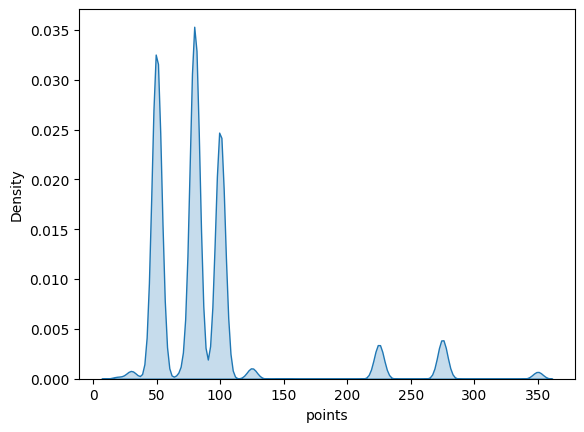

In [101]:
# Kernel Density Estimation
seaborn.kdeplot(df_races["points"], fill=True, label="points")
plt.show()

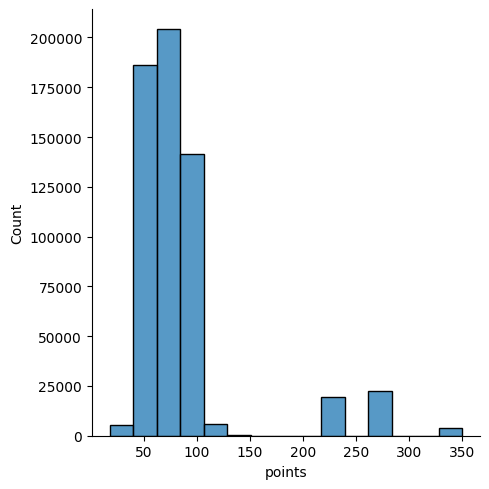

In [102]:
seaborn.displot(df_races,
            x="points",
            kind="hist",
            row_order="desc",
            bins=15)

Visual Inspection by Race Type or Category:
Since the distribution of points might vary significantly depending on factors like the race type, UCI points, and startlist quality, you should break down the data by these categories and examine how the imputed values behave within each subgroup. You can:
* Plot histograms or density plots of the points within each race type or profile (e.g., flat, mountainous, high mountains) before and after imputation.
    * If the imputation is reasonable, the general shape of the distribution within each subgroup should remain similar, with the imputed values filling gaps without significantly changing the overall patterns.


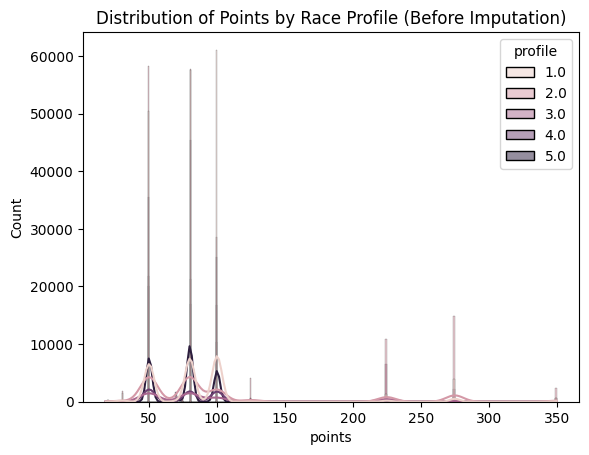

In [103]:
# Plot points distribution by race type (before imputation)
seaborn.histplot(data=df_races[df_races['points'].notnull()], x='points', hue='profile', kde=True)
plt.title("Distribution of Points by Race Profile (Before Imputation)")
plt.show()

Key Insights:

Distinct Point Clusters: Points seem to be distributed in specific clusters, with high counts around common point values (like 50, 100, 250). This suggests that points are often assigned in a standardized or tiered way, possibly based on the race type or prestige.

Race Profile Overlap: The different profiles (1.0 to 5.0) have significant overlap in point assignments. This means that, while some races may differ in difficulty or profile, they still frequently assign similar points.

High Peaks Around Standard Point Values: The peaks at specific values (like 50 and 100) are pronounced, showing that many races, regardless of profile, frequently assign these point values.

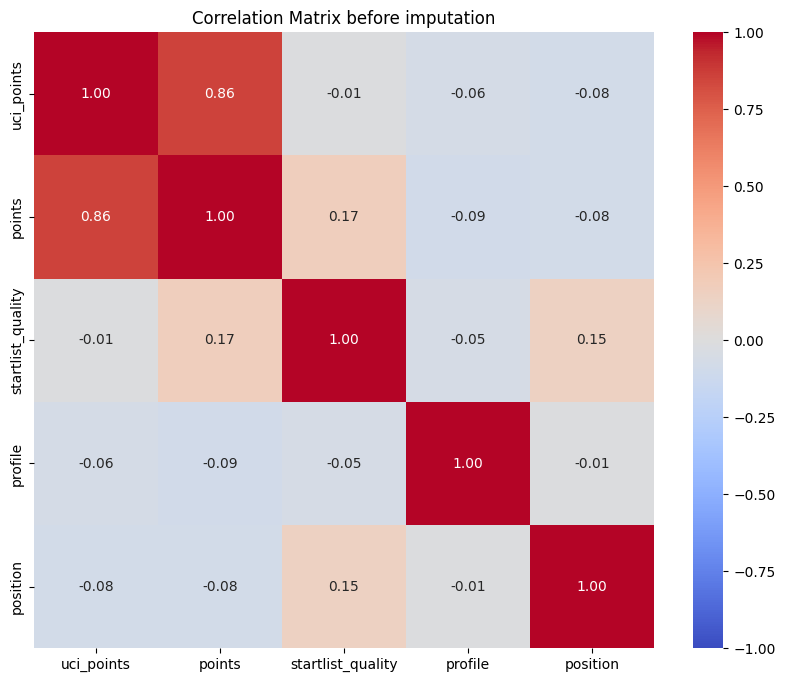

In [104]:
# check correlation before 
# Large shifts in correlation after imputation could indicate that the imputed values 
# deviate from the underlying relationships that exist in the data.
df_correlation = df_races[['uci_points', 'points', 'startlist_quality', 'profile', 'position']].copy()
corr_before = df_correlation[df_correlation['points'].notnull()].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
seaborn.heatmap(corr_before, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix before imputation")
plt.show()

## Select best K and impute with KNNRegressor

In [113]:
# Scale the data
scaler = StandardScaler()
columns_to_scale = ['points', 'startlist_quality', 'profile', 'position']
df_races[columns_to_scale] = scaler.fit_transform(df_races[columns_to_scale])

# Create a copy of the DataFrame for imputation while retaining all rows
df_no_nan = df_races.copy()

# Artificially mask some known values for testing
# Select non-null values to mask
known_points = df_no_nan['points'].notna()
points_non_null = df_no_nan.loc[known_points, 'points'].copy()
mask_fraction = 0.2  # Percentage of points to mask
mask_size = int(mask_fraction * len(points_non_null))
mask_indices = np.random.choice(points_non_null.index, mask_size, replace=False)

# Store the original values for error calculation
original_values = df_no_nan.loc[mask_indices, 'points'].copy()

# Mask the selected points
df_no_nan.loc[mask_indices, 'points'] = np.nan

# Test different k values for the imputer
k_values = [10, 15, 17, 20, 23, 30]  # range is adjusted because we made some tries before with more general values
weights_options = ['uniform', 'distance'] 
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

errors = {}

for k in k_values:
    for weight in weights_options:
        for algo in algorithms:
            # Initialize the imputer with the current k, weights, and algorithm
            imputer = IterativeImputer(
                estimator=KNeighborsRegressor(n_neighbors=k, weights=weight, algorithm=algo),
                random_state=0,
                max_iter=100,
                sample_posterior=False
            )
            
            # Fit and transform only on the copy with artificially masked values
            imputed_data = imputer.fit_transform(df_no_nan[columns_to_scale])
            df_imputed = pd.DataFrame(imputed_data, columns=columns_to_scale, index=df_no_nan.index)
            
            # Calculate error only on the masked points using the original values
            error = mean_squared_error(original_values, df_imputed.loc[mask_indices, 'points'])
            errors[(k, weight, algo)] = error

# Select the optimal parameters based on minimum error
optimal_params = min(errors, key=errors.get)
optimal_k, optimal_weight, optimal_algo = optimal_params

# Perform final imputation on the original DataFrame with the selected k
final_imputer = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=optimal_k, weights=optimal_weight, algorithm=optimal_algo),
    random_state=0,
    max_iter=100
)

# Fit and transform the original DataFrame, which includes real missing values
df_races[columns_to_scale] = final_imputer.fit_transform(df_races[columns_to_scale])

# Inverse the standardization
df_races[columns_to_scale] = scaler.inverse_transform(df_races[columns_to_scale])

# Output the optimal k and final imputed DataFrame
print(f"Optimal k: {optimal_k}, Optimal weights: '{optimal_weight}', Optimal algorithm: '{optimal_algo}'")


Optimal k: 20, Optimal weights: 'uniform', Optimal algorithm: 'brute'


# RandomForestRegressor

In [ ]:
# Scale the data
scaler = StandardScaler()
columns_to_scale = ['points', 'startlist_quality', 'profile', 'position']
df_races[columns_to_scale] = scaler.fit_transform(df_races[columns_to_scale])

# Create a copy of the DataFrame for imputation while retaining all rows
df_no_nan = df_races.copy()

# Artificially mask some known values for testing
# Select non-null values to mask
known_points = df_no_nan['points'].notna()
points_non_null = df_no_nan.loc[known_points, 'points'].copy()
mask_fraction = 0.2  # Percentage of points to mask
mask_size = int(mask_fraction * len(points_non_null))
mask_indices = np.random.choice(points_non_null.index, mask_size, replace=False)

# Store the original values for error calculation
original_values = df_no_nan.loc[mask_indices, 'points'].copy()

# Mask the selected points
df_no_nan.loc[mask_indices, 'points'] = np.nan

# Test different k values for the imputer
k_values = [3,5,7,15,20,30,50]
weights_options = ['uniform', 'distance'] 
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

errors = {}

for k in k_values:
    for weight in weights_options:
        for algo in algorithms:
            # Initialize the imputer with the current k, weights, and algorithm
            imputer = IterativeImputer(
                estimator=KNeighborsRegressor(n_neighbors=k, weights=weight, algorithm=algo),
                random_state=0,
                max_iter=100,
                sample_posterior=False
            )
            
            # Fit and transform only on the copy with artificially masked values
            imputed_data = imputer.fit_transform(df_no_nan[columns_to_scale])
            df_imputed = pd.DataFrame(imputed_data, columns=columns_to_scale, index=df_no_nan.index)
            
            # Calculate error only on the masked points using the original values
            error = mean_squared_error(original_values, df_imputed.loc[mask_indices, 'points'])
            errors[(k, weight, algo)] = error

# Select the optimal parameters based on minimum error
optimal_params = min(errors, key=errors.get)
optimal_k, optimal_weight, optimal_algo = optimal_params

# Perform final imputation on the original DataFrame with the selected k
final_imputer = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=optimal_k, weights=optimal_weight, algorithm=optimal_algo),
    random_state=0,
    max_iter=100
)

# Fit and transform the original DataFrame, which includes real missing values
df_races[columns_to_scale] = final_imputer.fit_transform(df_races[columns_to_scale])

# Inverse the standardization
df_races[columns_to_scale] = scaler.inverse_transform(df_races[columns_to_scale])

# Output the optimal k and final imputed DataFrame
print(f"Optimal k: {optimal_k}, Optimal weights: '{optimal_weight}', Optimal algorithm: '{optimal_algo}'")


# BayesianRidge (Best)

In [105]:
# Scale the data
scaler = StandardScaler()
columns_to_scale = ['points', 'startlist_quality', 'profile', 'position']
df_races[columns_to_scale] = scaler.fit_transform(df_races[columns_to_scale])

# Create a copy of the DataFrame for imputation while retaining all rows
df_no_nan = df_races.copy()

# Artificially mask some known values for testing
# Select non-null values to mask
known_points = df_no_nan['points'].notna()
points_non_null = df_no_nan.loc[known_points, 'points'].copy()
mask_fraction = 0.2  # Percentage of points to mask
mask_size = int(mask_fraction * len(points_non_null))
mask_indices = np.random.choice(points_non_null.index, mask_size, replace=False)

# Store the original values for error calculation
original_values = df_no_nan.loc[mask_indices, 'points'].copy()

# Mask the selected points
df_no_nan.loc[mask_indices, 'points'] = np.nan

# Test different hyperparameter values for Bayesian Ridge
max_iter_values = [100, 200, 300, 400, 500]  # Maximum number of iterations
tol_values = [1e-4, 1e-3, 1e-2]  # Tolerance levels for convergence

errors = {}

# Iterate through all combinations of max_iter and tol
for max_iter in max_iter_values:
    for tol in tol_values:
        # Initialize the imputer with Bayesian Ridge and current hyperparameters
        imputer = IterativeImputer(
            estimator=BayesianRidge(max_iter=max_iter, tol=tol),
            random_state=0,
            sample_posterior=True
        )
        
        # Fit and transform only on the copy with artificially masked values
        imputed_data = imputer.fit_transform(df_no_nan[columns_to_scale])
        df_imputed = pd.DataFrame(imputed_data, columns=columns_to_scale, index=df_no_nan.index)
        
        # Calculate error only on the masked points using the original values
        error = mean_squared_error(original_values, df_imputed.loc[mask_indices, 'points'])
        errors[(max_iter, tol)] = error

# Select the optimal parameters based on minimum error
optimal_params = min(errors, key=errors.get)
optimal_max_iter, optimal_tol = optimal_params

# Perform final imputation on the original DataFrame with the selected parameters
final_imputer = IterativeImputer(
    estimator=BayesianRidge(max_iter=optimal_max_iter, tol=optimal_tol),
    random_state=0,
    sample_posterior=True
)

# Fit and transform the original DataFrame, which includes real missing values
df_races[columns_to_scale] = final_imputer.fit_transform(df_races[columns_to_scale])

# Inverse the standardization
df_races[columns_to_scale] = scaler.inverse_transform(df_races[columns_to_scale])

# Output the optimal parameters and final imputed DataFrame
print(f"Optimal max_iter: {optimal_max_iter}, Optimal tol: {optimal_tol}")

Optimal max_iter: 100, Optimal tol: 0.0001


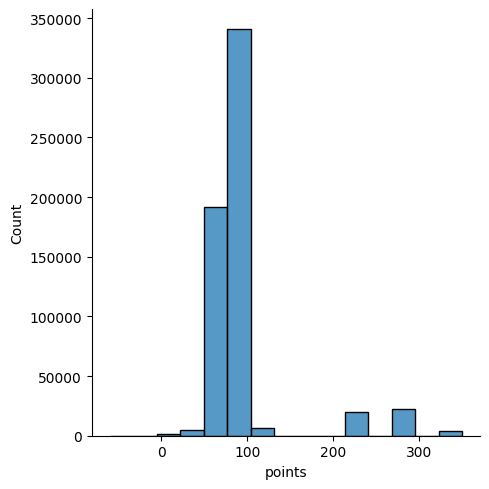

In [41]:
seaborn.displot(df_races,
            x="points",
            kind="hist",
            row_order="desc",
            bins=15)

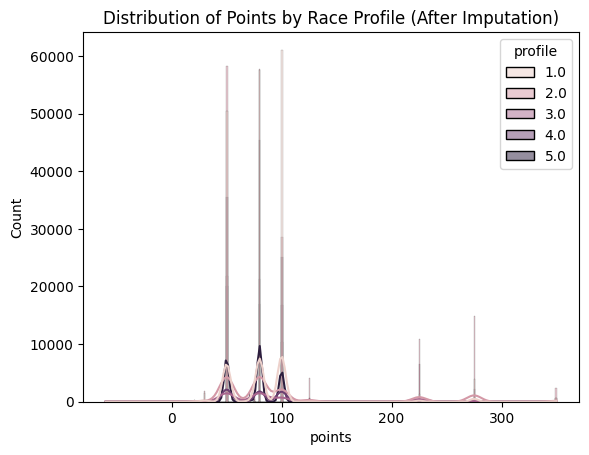

In [42]:
# Plot points distribution by race type (after imputation)
seaborn.histplot(data=df_races[df_races['points'].notnull()], x='points', hue='profile', kde=True)
plt.title("Distribution of Points by Race Profile (After Imputation)")
plt.show()

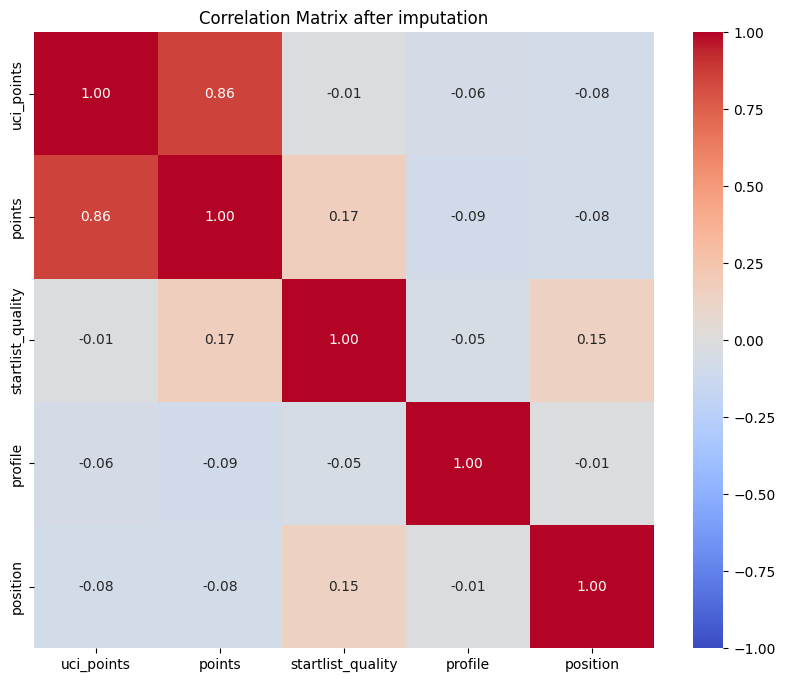

In [43]:
# check correlation after
df_correlation_after = df_races[['uci_points', 'points', 'startlist_quality', 'profile', 'position']].copy()
corr_after = df_correlation_after[df_correlation_after['points'].notnull()].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
seaborn.heatmap(corr_after, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix after imputation")
plt.show()

# Kolmogorov-Smirnov Test

In [44]:
# Kolmogorov-Smirnov Test

points_after_imputation = df_races['points']

statistic, p_value = ks_2samp(points_before_imputation, points_after_imputation)

# Print test results
print(f"\nKS Test: Statistic = {statistic}, p-value = {p_value}")

# Interpretation based on KS statistic ranges
if statistic < 0.05:
    print("Very small difference in distribution, the imputed data closely matches the original distribution.")
elif 0.05 <= statistic < 0.1:
    print("Minor difference in distribution, the imputed data is similar to the original distribution with slight deviations.")
elif 0.1 <= statistic < 0.2:
    print("Moderate difference in distribution, the imputed data shows some noticeable deviations from the original distribution.")
elif 0.2 <= statistic < 0.5:
    print("Significant difference in distribution, the imputed data may not fully preserve the original distribution.")
else:
    print("Large difference in distribution, the imputed data differs substantially from the original distribution.")


KS Test: Statistic = 0.0002950529718773742, p-value = 1.0
Very small difference in distribution, the imputed data closely matches the original distribution.


Probably 477 missing points on about 500000 yelds a p value of 1, since visually thee distribution is preserved

In [45]:
df_races.isnull().sum()

_url                        0
name                        0
points                      0
uci_points             338779
length                      0
climb_total                 0
profile                     0
startlist_quality           0
average_temperature    559880
date                        0
position                    0
cyclist                     0
cyclist_age                 0
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team           159161
delta                       0
dtype: int64

# UCI Points

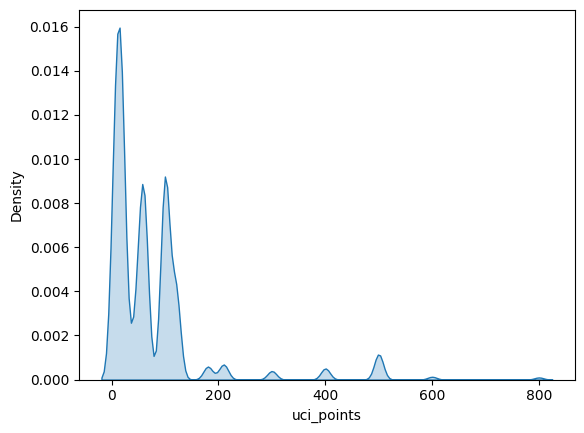

In [46]:
# Kernel Density Estimation UCI POINTS
seaborn.kdeplot(df_races["uci_points"], fill=True, label="uci_points")
plt.show()

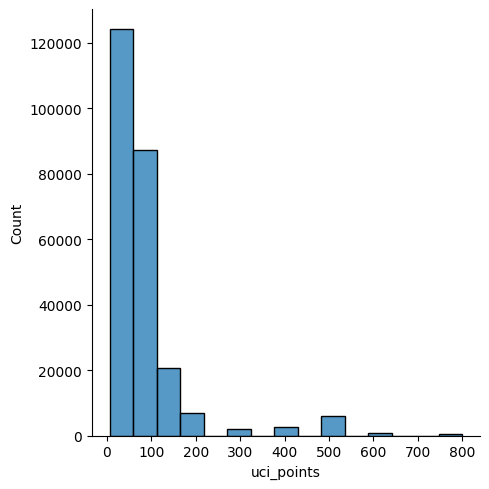

In [47]:
seaborn.displot(df_races,
            x="uci_points",
            kind="hist",
            row_order="desc",
            bins=15)

In [106]:
# Compute for testing after imputation
uci_points_before_imputation = df_races['uci_points'].dropna()

# look at general statistics to compare
original_stats = df_races[df_races['uci_points'].notnull()]['uci_points'].describe()
original_stats

count    251034.000000
mean         74.596604
std         100.954300
min           6.000000
25%          16.000000
50%          60.000000
75%         100.000000
max         800.000000
Name: uci_points, dtype: float64

# Select best K and impute KNNRegressor (Best)

In [107]:
# Scale the data
scaler = StandardScaler()
columns_to_scale = ['uci_points', 'points', 'startlist_quality', 'profile', 'position']
df_races[columns_to_scale] = scaler.fit_transform(df_races[columns_to_scale])

# Create a copy of the DataFrame for imputation while retaining all rows
df_no_nan = df_races.copy()

# Artificially mask some known values for testing
# Select non-null values to mask
known_points = df_no_nan['uci_points'].notna()
points_non_null = df_no_nan.loc[known_points, 'uci_points'].copy()
mask_fraction = 0.2  # Percentage of uci_points to mask
mask_size = int(mask_fraction * len(points_non_null))
mask_indices = np.random.choice(points_non_null.index, mask_size, replace=False)

# Store the original values for error calculation
original_values = df_no_nan.loc[mask_indices, 'uci_points'].copy()

# Mask the selected uci_points
df_no_nan.loc[mask_indices, 'uci_points'] = np.nan

# Test different k values for the imputer
k_values = [3,5,7,15,20]
weights_options = ['uniform', 'distance'] 
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

errors = {}

for k in k_values:
    for weight in weights_options:
        for algo in algorithms:
            # Initialize the imputer with the current k, weights, and algorithm
            imputer = IterativeImputer(
                estimator=KNeighborsRegressor(n_neighbors=k, weights=weight, algorithm=algo),
                random_state=0,
                max_iter=100
            )
            
            # Fit and transform only on the copy with artificially masked values
            imputed_data = imputer.fit_transform(df_no_nan[columns_to_scale])
            df_imputed = pd.DataFrame(imputed_data, columns=columns_to_scale, index=df_no_nan.index)
            
            # Calculate error only on the masked points using the original values
            error = mean_squared_error(original_values, df_imputed.loc[mask_indices, 'uci_points'])
            errors[(k, weight, algo)] = error

# Select the optimal parameters based on minimum error
optimal_params = min(errors, key=errors.get)
optimal_k, optimal_weight, optimal_algo = optimal_params

# Perform final imputation on the original DataFrame with the selected k
final_imputer = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=optimal_k, weights=optimal_weight, algorithm=optimal_algo),
    random_state=0,
    max_iter=100
)

# Fit and transform the original DataFrame, which includes real missing values
df_races[columns_to_scale] = final_imputer.fit_transform(df_races[columns_to_scale])

# Inverse the standardization
df_races[columns_to_scale] = scaler.inverse_transform(df_races[columns_to_scale])

# Output the optimal k and final imputed DataFrame
print(f"Optimal k: {optimal_k}, Optimal weights: '{optimal_weight}', Optimal algorithm: '{optimal_algo}'")


Optimal k: 3, Optimal weights: 'distance', Optimal algorithm: 'auto'


# RandomForestRegressor

# BayesianRidge

In [157]:
# Scale the data
scaler = StandardScaler()
columns_to_scale = ['uci_points', 'points', 'startlist_quality', 'profile', 'position']
df_races[columns_to_scale] = scaler.fit_transform(df_races[columns_to_scale])

# Create a copy of the DataFrame for imputation while retaining all rows
df_no_nan = df_races.copy()

# Artificially mask some known values for testing
# Select non-null values to mask
known_points = df_no_nan['uci_points'].notna()
points_non_null = df_no_nan.loc[known_points, 'uci_points'].copy()
mask_fraction = 0.2  # Percentage of uci_points to mask
mask_size = int(mask_fraction * len(points_non_null))
mask_indices = np.random.choice(points_non_null.index, mask_size, replace=False)

# Store the original values for error calculation
original_values = df_no_nan.loc[mask_indices, 'uci_points'].copy()

# Mask the selected points
df_no_nan.loc[mask_indices, 'uci_points'] = np.nan

# Test different hyperparameter values for Bayesian Ridge
max_iter_values = [100, 200, 300, 400, 500]  # Maximum number of iterations
tol_values = [1e-4, 1e-3, 1e-2]  # Tolerance levels for convergence

errors = {}

# Iterate through all combinations of max_iter and tol
for max_iter in max_iter_values:
    for tol in tol_values:
        # Initialize the imputer with Bayesian Ridge and current hyperparameters
        imputer = IterativeImputer(
            estimator=BayesianRidge(max_iter=max_iter, tol=tol),
            random_state=0,
            sample_posterior=True
        )
        
        # Fit and transform only on the copy with artificially masked values
        imputed_data = imputer.fit_transform(df_no_nan[columns_to_scale])
        df_imputed = pd.DataFrame(imputed_data, columns=columns_to_scale, index=df_no_nan.index)
        
        # Calculate error only on the masked points using the original values
        error = mean_squared_error(original_values, df_imputed.loc[mask_indices, 'uci_points'])
        errors[(max_iter, tol)] = error

# Select the optimal parameters based on minimum error
optimal_params = min(errors, key=errors.get)
optimal_max_iter, optimal_tol = optimal_params

# Perform final imputation on the original DataFrame with the selected parameters
final_imputer = IterativeImputer(
    estimator=BayesianRidge(max_iter=optimal_max_iter, tol=optimal_tol),
    random_state=0,
    sample_posterior=True
)

# Fit and transform the original DataFrame, which includes real missing values
df_races[columns_to_scale] = final_imputer.fit_transform(df_races[columns_to_scale])

# Inverse the standardization
df_races[columns_to_scale] = scaler.inverse_transform(df_races[columns_to_scale])

# Output the optimal parameters and final imputed DataFrame
print(f"Optimal max_iter: {optimal_max_iter}, Optimal tol: {optimal_tol}")

Optimal max_iter: 100, Optimal tol: 0.0001


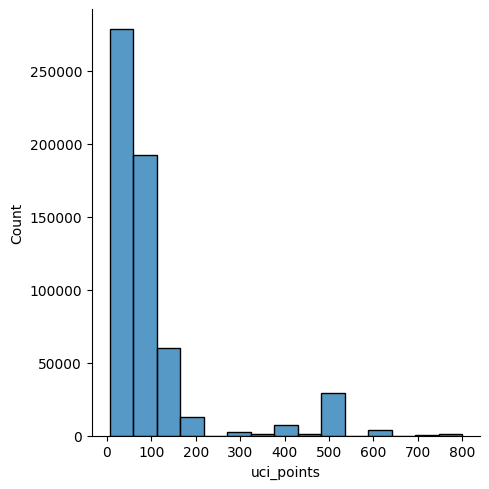

In [108]:
seaborn.displot(df_races,
            x="uci_points",
            kind="hist",
            row_order="desc",
            bins=15)

In [109]:
# check stats after imputation (outlier induce error on max min maybe ??)
imputed_stats = df_races['uci_points'].describe()
imputed_stats

count    589813.000000
mean         90.106721
std         124.232584
min           6.000000
25%          16.000000
50%          60.000000
75%         100.000000
max         800.000000
Name: uci_points, dtype: float64

# Kolmogorov-Smirnov Test

In [110]:
# Kolmogorov-Smirnov Test

uci_points_after_imputation = df_races['uci_points']

statistic, p_value = ks_2samp(uci_points_before_imputation, uci_points_after_imputation)

# Print test results
print(f"\nKS Test: Statistic = {statistic}, p-value = {p_value}")

# Interpretation based on KS statistic ranges
if statistic < 0.05:
    print("Very small difference in distribution, the imputed data closely matches the original distribution.")
elif 0.05 <= statistic < 0.1:
    print("Minor difference in distribution, the imputed data is similar to the original distribution with slight deviations.")
elif 0.1 <= statistic < 0.2:
    print("Moderate difference in distribution, the imputed data shows some noticeable deviations from the original distribution.")
elif 0.2 <= statistic < 0.5:
    print("Significant difference in distribution, the imputed data may not fully preserve the original distribution.")
else:
    print("Large difference in distribution, the imputed data differs substantially from the original distribution.")


KS Test: Statistic = 0.06872138470245942, p-value = 0.0
Minor difference in distribution, the imputed data is similar to the original distribution with slight deviations.


A p value of 0 could be justyfied with large sample size and missing value counts (about 70% over the total). So the difference in the actual distribution are not too much, but the statistics obviously sufferf major change because we addes some more values

In [53]:
df_races.isnull().sum()

_url                        0
name                        0
points                      0
uci_points                  0
length                      0
climb_total                 0
profile                     0
startlist_quality           0
average_temperature    559880
date                        0
position                    0
cyclist                     0
cyclist_age                 0
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team           159161
delta                       0
dtype: int64

# Cyclist team

To impute the missing cyclist_team attribute, the following features can be most helpful for prediction:

Race Attributes:

Name: Certain teams might specialize in specific races or are more likely to be represented in certain high-prestige races (e.g., Tour de France).
Points and Alternative Points: High-point races may attract specific teams with a strong track record or history in those races.
Total Meters Climbed and Race Profile: Teams often have rosters built for specific types of races (e.g., flat vs. mountainous); some teams are known for having climbers while others specialize in flat stages.
Is_X: Certain teams have cyclists skilled in specific race types (e.g., gravel races).
Startlist Quality: This indicates the general level of competition, which could correlate with specific high-ranking teams present in more competitive races.
Cyclist Attributes:


Length of the Race: Some teams specialize in shorter vs. longer races or stages, which may inform their likely presence in specific race types.

In [111]:
df_races["cyclist_team"].describe()

count                              430652
unique                                 91
top       liberty-seguros-wurth-team-2005
freq                                 8869
Name: cyclist_team, dtype: object

In [112]:
# Calculate distribution before imputation
before_imputation_dist = df_races['cyclist_team'].value_counts(normalize=True)

# Compute for testing after imputation
cyclist_team_before_imputation = df_races['cyclist_team'].dropna()

Text(0, 0.5, 'Frequency')

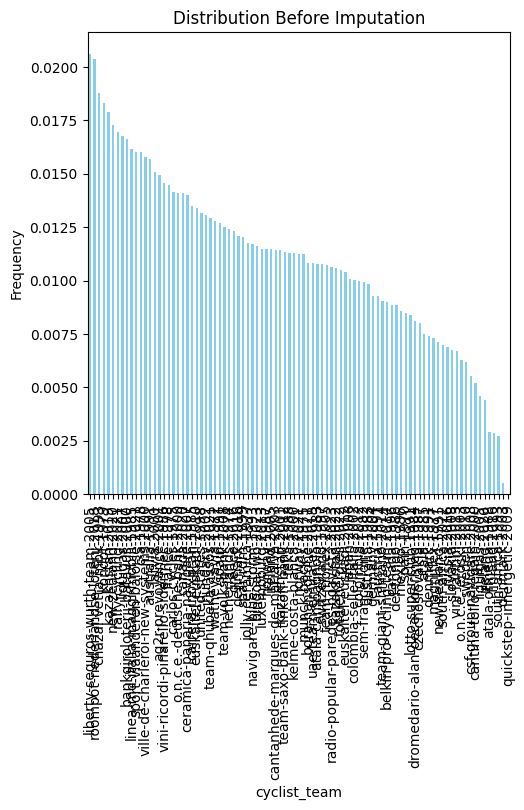

In [113]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
before_imputation_dist.plot(kind='bar', color='skyblue')
plt.title("Distribution Before Imputation")
plt.ylabel("Frequency")

### Set values to Nan because of string poblem

In [114]:
df_races[["cyclist_team"]].head() # NaN calues are set to --> None
# convert them
df_races["cyclist_team"] = df_races["cyclist_team"].replace({None: np.nan})

In [116]:
df_races["cyclist_team"]

0         vini-ricordi-pinarello-sidermec-1986
1                                  norway-1987
2                                          NaN
3                     navigare-blue-storm-1993
4                                   spain-1991
                          ...                 
589860                        watney-avia-1972
589861                                     NaN
589862                         kazakhstan-2001
589863     radio-popular-paredes-boavista-2023
589864                         kazakhstan-2001
Name: cyclist_team, Length: 589813, dtype: object

# Try simple imputer with most frequent strategy

In [112]:
# Simple imputer
imputer = SimpleImputer(strategy='most_frequent')
df_races["cyclist_team"] = imputer.fit_transform(df_races[["cyclist_team"]]).squeeze()

print("Missing values after imputation are:")
print(df_races["cyclist_team"].isnull().sum())

0


# KNNRegressor

In [117]:
# Encode cyclist team with categorical encoding
label_encoder = LabelEncoder()
label_encoder2 = LabelEncoder()
df_races['cyclist_team'] = label_encoder.fit_transform(df_races['cyclist_team'])
df_races['name'] = label_encoder2.fit_transform(df_races['name'])

# Scale the data
scaler = StandardScaler()
columns_to_scale = ['cyclist_team', 'name', 'points', 'uci_points', 'startlist_quality', 'profile', 'length', 'climb_total']
df_races[['points', 'uci_points', 'startlist_quality', 'profile', 'length', 'climb_total']] = scaler.fit_transform(df_races[['points', 'uci_points', 'startlist_quality', 'profile', 'length', 'climb_total']])

# Create a copy of the DataFrame for imputation while retaining all rows
df_no_nan = df_races.copy()

# Artificially mask some known values for testing
# Select non-null values to mask
known_points = df_no_nan['cyclist_team'].notna()
points_non_null = df_no_nan.loc[known_points, 'cyclist_team'].copy()
mask_fraction = 0.2  # Percentage of cyclist_team to mask
mask_size = int(mask_fraction * len(points_non_null))
mask_indices = np.random.choice(points_non_null.index, mask_size, replace=False)

# Store the original values for error calculation
original_values = df_no_nan.loc[mask_indices, 'cyclist_team'].copy()

# Mask the selected cyclist_team
df_no_nan.loc[mask_indices, 'cyclist_team'] = np.nan

# Test different k values for the imputer
k_values = [3,5,7,15,20]
weights_options = ['uniform', 'distance'] 
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

errors = {}

for k in k_values:
    for weight in weights_options:
        for algo in algorithms:
            # Initialize the imputer with the current k, weights, and algorithm
            imputer = IterativeImputer(
                estimator=KNeighborsRegressor(n_neighbors=k, weights=weight, algorithm=algo),
                random_state=0,
                max_iter=100
            )
            
            # Fit and transform only on the copy with artificially masked values
            imputed_data = imputer.fit_transform(df_no_nan[columns_to_scale])
            df_imputed = pd.DataFrame(imputed_data, columns=columns_to_scale, index=df_no_nan.index)
            
            # Calculate error only on the masked points using the original values
            error = mean_squared_error(original_values, df_imputed.loc[mask_indices, 'cyclist_team'])
            errors[(k, weight, algo)] = error

# Select the optimal parameters based on minimum error
optimal_params = min(errors, key=errors.get)
optimal_k, optimal_weight, optimal_algo = optimal_params

# Perform final imputation on the original DataFrame with the selected k
final_imputer = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=optimal_k, weights=optimal_weight, algorithm=optimal_algo),
    random_state=0,
    max_iter=100
)

# Fit and transform the original DataFrame, which includes real missing values
df_races[columns_to_scale] = final_imputer.fit_transform(df_races[columns_to_scale])

# Inverse the standardization
df_races[columns_to_scale] = scaler.inverse_transform(df_races[columns_to_scale])

# Ensure integer type after imputation for categorical columns
df_races['cyclist_team'] = df_races['cyclist_team'].round().astype(int)
df_races['name'] = df_races['name'].round().astype(int)

# Inverse label encoding
df_races['cyclist_team'] = label_encoder.inverse_transform(df_races['cyclist_team'])
df_races['name'] = label_encoder2.inverse_transform(df_races['name'])

# Output the optimal k and final imputed DataFrame
print(f"Optimal k: {optimal_k}, Optimal weights: '{optimal_weight}', Optimal algorithm: '{optimal_algo}'")


ValueError: operands could not be broadcast together with shapes (589813,8) (6,) (589813,8) 

# BayesianRidge

In [118]:
# Encode cyclist team with categorical encoding
label_encoder = LabelEncoder()
label_encoder2 = LabelEncoder()
df_races['cyclist_team'] = label_encoder.fit_transform(df_races['cyclist_team'])
df_races['name'] = label_encoder2.fit_transform(df_races['name'])

# Scale the data
scaler = StandardScaler()
columns_to_scale = ['cyclist_team', 'name', 'points', 'uci_points', 'startlist_quality', 'profile', 'length', 'climb_total']
df_races[['points', 'uci_points', 'startlist_quality', 'profile', 'length', 'climb_total']] = scaler.fit_transform(df_races[['points', 'uci_points', 'startlist_quality', 'profile', 'length', 'climb_total']])

# Create a copy of the DataFrame for imputation while retaining all rows
df_no_nan = df_races.copy()

# Artificially mask some known values for testing
# Select non-null values to mask
known_points = df_no_nan['cyclist_team'].notna()
points_non_null = df_no_nan.loc[known_points, 'cyclist_team'].copy()
mask_fraction = 0.2  # Percentage of cyclist_team to mask
mask_size = int(mask_fraction * len(points_non_null))
mask_indices = np.random.choice(points_non_null.index, mask_size, replace=False)

# Store the original values for error calculation
original_values = df_no_nan.loc[mask_indices, 'cyclist_team'].copy()

# Mask the selected points
df_no_nan.loc[mask_indices, 'cyclist_team'] = np.nan

# Test different hyperparameter values for Bayesian Ridge
max_iter_values = [100, 200, 300, 400, 500]  # Maximum number of iterations
tol_values = [1e-4, 1e-3, 1e-2]  # Tolerance levels for convergence

errors = {}

# Iterate through all combinations of max_iter and tol
for max_iter in max_iter_values:
    for tol in tol_values:
        # Initialize the imputer with Bayesian Ridge and current hyperparameters
        imputer = IterativeImputer(
            estimator=BayesianRidge(max_iter=max_iter, tol=tol),
            random_state=0,
            sample_posterior=True
        )
        
        # Fit and transform only on the copy with artificially masked values
        imputed_data = imputer.fit_transform(df_no_nan[columns_to_scale])
        df_imputed = pd.DataFrame(imputed_data, columns=columns_to_scale, index=df_no_nan.index)
        
        # Calculate error only on the masked points using the original values
        error = mean_squared_error(original_values, df_imputed.loc[mask_indices, 'cyclist_team'])
        errors[(max_iter, tol)] = error

# Select the optimal parameters based on minimum error
optimal_params = min(errors, key=errors.get)
optimal_max_iter, optimal_tol = optimal_params

# Perform final imputation on the original DataFrame with the selected parameters
final_imputer = IterativeImputer(
    estimator=BayesianRidge(max_iter=optimal_max_iter, tol=optimal_tol),
    random_state=0,
    sample_posterior=True
)

# Fit and transform the original DataFrame, which includes real missing values
df_races[columns_to_scale] = final_imputer.fit_transform(df_races[columns_to_scale])

# Inverse the standardization
df_races[['points', 'uci_points', 'startlist_quality', 'profile', 'length', 'climb_total']] = scaler.inverse_transform(df_races[['points', 'uci_points', 'startlist_quality', 'profile', 'length', 'climb_total']])

# Ensure integer type after imputation for categorical columns
df_races['cyclist_team'] = df_races['cyclist_team'].round().astype(int)
df_races['name'] = df_races['name'].round().astype(int)

# Inverse label encoding
df_races['cyclist_team'] = label_encoder.inverse_transform(df_races['cyclist_team'])
df_races['name'] = label_encoder2.inverse_transform(df_races['name'])

# Output the optimal parameters and final imputed DataFrame
print(f"Optimal max_iter: {optimal_max_iter}, Optimal tol: {optimal_tol}")

KeyboardInterrupt: 

Text(0, 0.5, 'Frequency')

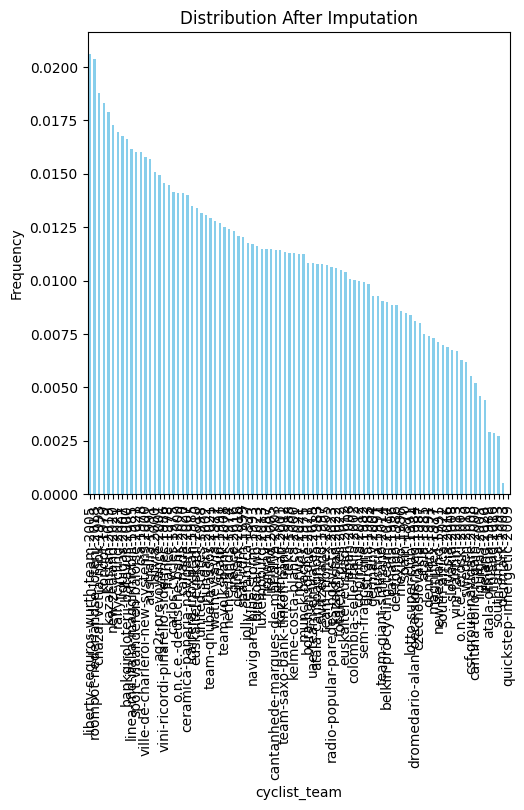

In [63]:
# Calculate distribution after imputation
after_imputation_dist = df_races['cyclist_team'].value_counts(normalize=True)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
after_imputation_dist.plot(kind='bar', color='skyblue')
plt.title("Distribution After Imputation")
plt.ylabel("Frequency")

# Kolmogorov-smirnov Test

In [59]:
# Kolmogorov-Smirnov Test

cyclist_team_after_imputation = df_races['cyclist_team']

statistic, p_value = ks_2samp(cyclist_team_before_imputation, cyclist_team_after_imputation)

# Print test results
print(f"\nKS Test: Statistic = {statistic}, p-value = {p_value}")

# Interpretation based on KS statistic ranges
if statistic < 0.05:
    print("Very small difference in distribution, the imputed data closely matches the original distribution.")
elif 0.05 <= statistic < 0.1:
    print("Minor difference in distribution, the imputed data is similar to the original distribution with slight deviations.")
elif 0.1 <= statistic < 0.2:
    print("Moderate difference in distribution, the imputed data shows some noticeable deviations from the original distribution.")
elif 0.2 <= statistic < 0.5:
    print("Significant difference in distribution, the imputed data may not fully preserve the original distribution.")
else:
    print("Large difference in distribution, the imputed data differs substantially from the original distribution.")

TypeError: '<' not supported between instances of 'NoneType' and 'str'

In [ ]:
df_races.isnull().sum()

# Temperature

In [64]:
# Delete the 'average_temperature' column
df_races = df_races.drop(columns=['average_temperature'])
df_races.isnull().sum()

KeyError: "['average_temperature'] not found in axis"